In [1]:
import os
import cv2
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import MultiHeadAttention

2025-06-29 08:23:23.665068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751185403.687180    1314 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751185403.693940    1314 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [ ]:
def build_generator(noise_dim, output_channels=3, activation='tanh', alpha=0.2):
    inputs = layers.Input(shape=(noise_dim,), name='noise_input')
    x = layers.Dense(4 * 4 * 512, use_bias=False)(inputs)
    x = layers.Reshape((4, 4, 512))(x)

    
    for filters in [512, 256, 128, 64]:
        x = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x)
        x = layers.Conv2D(filters, (5, 5), padding='same', use_bias=False)(x)

        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha)(x)

        
        if filters == 128:
           
            seq = layers.Reshape((32*32, 128))(x)
            attn_out = MultiHeadAttention(num_heads=4, key_dim=128//8)(seq, seq)
            seq = layers.Add()([seq, attn_out])
            x = layers.Reshape((32, 32, 128))(seq)

        if filters == 64:
            x = layers.Dropout(0.5)(x)

    outputs = layers.Conv2D(output_channels, (5, 5),
                            strides=(1, 1), padding='same',
                            activation=activation,
                            use_bias=False, dtype='float32')(x)
    assert outputs.shape == (None, 64, 64, output_channels)
    return tf.keras.Model(inputs, outputs, name='generator')

In [4]:
def build_discriminator(img_shape, activation='linear', alpha=0.2):
    inputs = layers.Input(shape=img_shape, name='image_input')
    x = inputs
    for filters in [64, 128, 256, 512]:
        x = layers.Conv2D(filters, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        x = layers.LeakyReLU(alpha)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation=activation, dtype='float32')(x)
    return tf.keras.Model(inputs, outputs, name='discriminator')


In [ ]:
class WGAN_GP(tf.keras.models.Model):
    def __init__(self, discriminator, generator, noise_dim,
                 discriminator_extra_steps=5, gp_weight=10.0):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise_dim = noise_dim
        self.discriminator_extra_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, **kwargs):
        super().compile(**kwargs)
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def add_instance_noise(self, x, stddev=0.1):
        noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=stddev, dtype=x.dtype)
        return x + noise

    def gradient_penalty(self, real, fake):
        batch_size = tf.shape(real)[0]
        epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        interp = epsilon * real + (1 - epsilon) * fake
        with tf.GradientTape() as tape:
            tape.watch(interp)
            pred = self.discriminator(interp, training=True)
        grads = tape.gradient(pred, interp)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]) + 1e-12)
        return tf.reduce_mean((norm - 1.0) ** 2)
    @tf.function
    def train_step(self, real_images):
       
        if isinstance(real_images, (tuple, list)):
            real_images = real_images[0]
       
        d_losses, gp_vals = [], []
        for _ in range(self.discriminator_extra_steps):
            batch_size = tf.shape(real_images)[0]
            noise = tf.random.normal([batch_size, self.noise_dim])

          
            real_noisy = self.add_instance_noise(real_images)
            fake_images = self.generator(noise, training=True)
            fake_noisy = self.add_instance_noise(fake_images)

            with tf.GradientTape() as tape:
                d_real = self.discriminator(real_noisy, training=True)
                d_fake = self.discriminator(fake_noisy, training=True)
                gp = self.gradient_penalty(real_noisy, fake_noisy)
                d_loss = self.d_loss_fn(d_real, d_fake) + self.gp_weight * gp
            grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

            d_losses.append(d_loss)
            gp_vals.append(gp)

        
        noise = tf.random.normal([tf.shape(real_images)[0], self.noise_dim])
        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            d_fake = self.discriminator(fake_images, training=True)
            g_loss = self.g_loss_fn(d_fake)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        return {
            'd_loss': tf.reduce_mean(d_losses),
            'g_loss': g_loss,
            'gp': tf.reduce_mean(gp_vals)
        }

In [ ]:
class ResultsCallback(tf.keras.callbacks.Callback):
    def __init__(self, noise_dim, output_path, examples=16, grid=(4,4), spacing=5,
                 gif_size=(416,416), duration=0.04, save_model=True):
        super().__init__()
        self.seed = tf.random.normal([examples, noise_dim])
        self.results = []
        self.out_dir = os.path.join(output_path, 'results')
        os.makedirs(self.out_dir, exist_ok=True)
        self.grid, self.spacing = grid, spacing
        self.gif_size, self.duration = gif_size, duration
        self.save_model = save_model

    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.generator(self.seed, training=False)
        imgs = ((preds * 127.5) + 127.5).numpy().astype(np.uint8)


        h, w, c = imgs.shape[1:]
        grid = np.zeros((self.grid[0]*h + (self.grid[0]-1)*self.spacing,
                         self.grid[1]*w + (self.grid[1]-1)*self.spacing, c), dtype=np.uint8)
        for i in range(self.grid[0]):
            for j in range(self.grid[1]):
                grid[i*(h+self.spacing):i*(h+self.spacing)+h,
                     j*(w+self.spacing):j*(w+self.spacing)+w] = imgs[i*self.grid[1]+j]

        cv2.imwrite(f'{self.out_dir}/img_{epoch}.png', cv2.cvtColor(grid, cv2.COLOR_RGB2BGR))
        self.results.append(cv2.resize(grid, self.gif_size, interpolation=cv2.INTER_AREA))

        if self.save_model:
            mdir = os.path.join(self.out_dir, 'models')
            os.makedirs(mdir, exist_ok=True)
            self.model.generator.save(os.path.join(mdir, f'gen_{epoch}.h5'))
            self.model.discriminator.save(os.path.join(mdir, f'disc_{epoch}.h5'))

    def on_train_end(self, logs=None):
        imgs = [imageio.core.util.Image(img[...,::-1]) for img in self.results]
        imageio.mimsave(os.path.join(self.out_dir, 'output.gif'), imgs, duration=self.duration)


In [7]:
class LRScheduler(tf.keras.callbacks.Callback):
    def __init__(self, decay_epochs, min_lr=2e-5, tb=None):
        super().__init__()
        self.decay_epochs = decay_epochs
        self.min_lr = min_lr
        self.tb = tb

    def on_epoch_end(self, epoch, logs=None):
        if epoch < self.decay_epochs:
            scale = 1 - epoch/self.decay_epochs
            new_lr = max(self.model.g_optimizer.learning_rate.numpy() * scale, self.min_lr)
            self.model.g_optimizer.learning_rate.assign(new_lr)
            self.model.d_optimizer.learning_rate.assign(new_lr)
            print(f"Epoch {epoch}: lr={new_lr:.6f}")
            if self.tb:
                with self.tb._writers['train'].as_default():
                    tf.summary.scalar('lr', new_lr, step=epoch)

In [ ]:

    
    data_dir = '/kaggle/input/50k-celeba-dataset-64x64'
    out_dir = 'Models/02_WGANGP_faces'
    os.makedirs(out_dir, exist_ok=True)

    batch_size = 128
    img_shape = (64, 64, 3)
    noise_dim = 128
   

    
    datagen = ImageDataGenerator(
        preprocessing_function=lambda x: (x/127.5)-1.0,
        horizontal_flip=True
    )
    train_gen = datagen.flow_from_directory(
        data_dir, target_size=img_shape[:2], batch_size=batch_size,
        class_mode=None, shuffle=True
    )


Found 50000 images belonging to 1 classes.


In [9]:
gen = build_generator(noise_dim)
disc = build_discriminator(img_shape)


I0000 00:00:1751185424.764565    1314 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
d_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0, beta_2=0.9)
g_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0, beta_2=0.9)

In [11]:
def d_loss_fn(real, fake): return tf.reduce_mean(fake) - tf.reduce_mean(real)
def g_loss_fn(fake): return -tf.reduce_mean(fake)

In [12]:
wgan = WGAN_GP(disc, gen, noise_dim, discriminator_extra_steps=5, gp_weight=10.0)
wgan.compile(d_opt, g_opt, d_loss_fn, g_loss_fn, run_eagerly=False)

In [13]:
epochs=10

In [14]:
tb = TensorBoard(log_dir=os.path.join(out_dir, 'logs'))
cb_results = ResultsCallback(noise_dim, out_dir)
cb_lr = LRScheduler(decay_epochs=epochs, min_lr=2e-5, tb=tb)


In [15]:
gen.load_weights("/kaggle/working/Models/02_WGANGP_faces/results/models/gen_18.h5")
disc.load_weights("/kaggle/working/Models/02_WGANGP_faces/results/models/disc_18.h5")

In [16]:
wgan.fit(train_gen, epochs=epochs, callbacks=[cb_results, tb, cb_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1751185448.474080    1369 service.cc:148] XLA service 0x7d44a0004060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751185448.474127    1369 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751185450.587347    1369 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751185505.060944    1369 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - d_loss: -2.2260 - g_loss: 1.5938 - gp: 0.0256Epoch 0: lr=0.000100
391/391 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - d_loss: -2.2239 - g_loss: 1.6096 - gp: 0.0256
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - d_loss: -2.4691 - g_loss: 1.3316 - gp: 0.0261Epoch 1: lr=0.000090
391/391 ━━━━━━━━━━━━━━━━━━━━ 368s 942ms/step - d_loss: -2.4703 - g_loss: 1.3245 - gp: 0.0261
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - d_loss: -2.4298 - g_loss: 0.9532 - gp: 0.0232Epoch 2: lr=0.000072
391/391 ━━━━━━━━━━━━━━━━━━━━ 368s 942ms/step - d_loss: -2.4320 - g_loss: 0.8839 - gp: 0.0233
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - d_loss: -2.3495 - g_loss: 0.7199 - gp: 0.0197Epoch 3: lr=0.000050
391/391 ━━━━━━━━━━━━━━━━━━━━ 368s 942ms/step - d_loss: -2.3521 - g_loss: 0.7179 - gp: 0.0197
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - d_loss: -2.2354 - g_loss: 0.5479 - gp: 0.0158Epoch 4: lr=0.000030
391/391 ━━━━━━━━━━━━━━━━━━━━ 368s 9

GPU configuration error: Physical devices cannot be modified after being initialized
=== GAN Evaluation (5000 samples) ===
Extracting 5000 images from data generator...
Real images shape: (5000, 64, 64, 3)
Generating 5000 fake images...
Fake images shape: (5000, 64, 64, 3)
Loading pre-trained models...
Models loaded successfully!
Calculating FID...
✓ FID Score: 23.32
Calculating Inception Score...
✓ Inception Score: 2.64 ± 0.11
Generating samples for visualization...


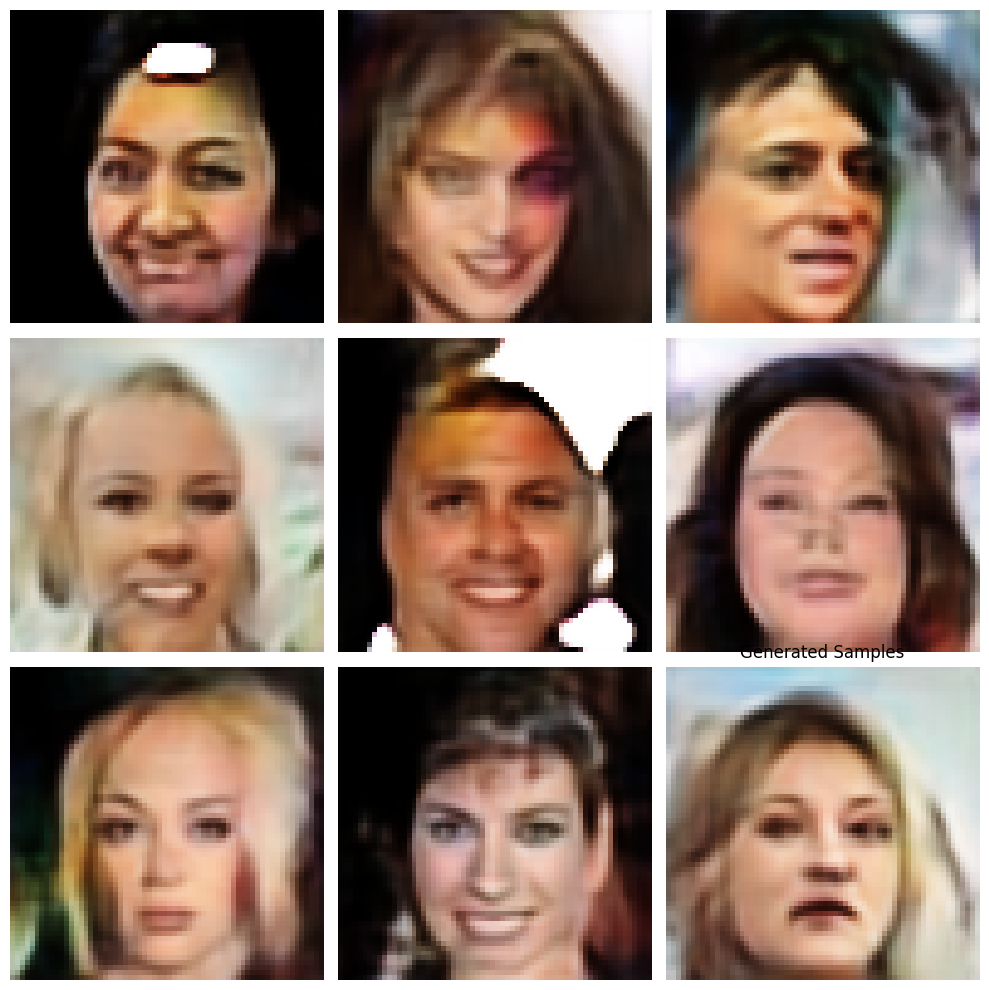


=== Results Summary ===
FID: 23.3208
IS_mean: 2.6383702754974365
IS_std: 0.11170428991317749


In [ ]:
import tensorflow as tf
import numpy as np
from scipy.linalg import sqrtm
from scipy.stats import entropy
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import cv2



class GANMetrics:
    def __init__(self):
        print("Loading pre-trained models...")
       
        self.inception_features = InceptionV3(
            include_top=False, 
            pooling='avg', 
            input_shape=(299, 299, 3),
            weights='imagenet'
        )
        
        
        self.inception_classifier = InceptionV3(
            include_top=True, 
            input_shape=(299, 299, 3),
            weights='imagenet'
        )
        print("Models loaded successfully!")
    
    def preprocess_for_inception(self, images):
       
        
        if tf.is_tensor(images):
            images = images.numpy()
        
        
        if len(images.shape) == 3:
            images = np.expand_dims(images, axis=0)
        

        if images.max() <= 1.0:
            images = images * 255.0
        elif images.min() < 0:
            images = (images + 1) * 127.5
        
        images = np.clip(images, 0, 255).astype(np.uint8)
        
        processed = []
        for img in images:
            
            if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[-1] == 1):
                if len(img.shape) == 3:
                    img = img[:, :, 0]
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            
            
            img_resized = cv2.resize(img, (299, 299))
            processed.append(img_resized)
        
        processed = np.array(processed, dtype=np.float32)
        return preprocess_input(processed)
    
    def calculate_fid(self, real_images, fake_images):
        
        print("Calculating FID...")
        

        real_prep = self.preprocess_for_inception(real_images)
        fake_prep = self.preprocess_for_inception(fake_images)
        
        
        real_features = self.inception_features.predict(real_prep, batch_size=32, verbose=0)
        fake_features = self.inception_features.predict(fake_prep, batch_size=32, verbose=0)
        
        
        mu_real = np.mean(real_features, axis=0)
        sigma_real = np.cov(real_features, rowvar=False)
        
        mu_fake = np.mean(fake_features, axis=0)
        sigma_fake = np.cov(fake_features, rowvar=False)
        
        
        diff = mu_real - mu_fake
        covmean = sqrtm(sigma_real @ sigma_fake)
        
        
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        
        fid = np.sum(diff**2) + np.trace(sigma_real + sigma_fake - 2*covmean)
        return float(fid)
    
    def calculate_inception_score(self, fake_images, splits=10):
        
        print("Calculating Inception Score...")
        
        
        fake_prep = self.preprocess_for_inception(fake_images)
        
        
        preds = self.inception_classifier.predict(fake_prep, batch_size=32, verbose=0)
        
        
        scores = []
        n_part = len(preds) // splits
        
        for i in range(splits):
            start_idx = i * n_part
            end_idx = start_idx + n_part if i < splits - 1 else len(preds)
            part = preds[start_idx:end_idx]
            
            
            p_y = np.mean(part, axis=0)
            kl_divs = []
            for p_yx in part:
                kl_div = entropy(p_yx, p_y)
                kl_divs.append(kl_div)
            
            scores.append(np.exp(np.mean(kl_divs)))
        
        return np.mean(scores), np.std(scores)

def extract_real_images(data_source, num_samples=100):
   
    real_images = []
    

    if hasattr(data_source, 'next') or 'Iterator' in str(type(data_source)):
        print(f"Extracting {num_samples} images from data generator...")
        
        
        if hasattr(data_source, 'reset'):
            data_source.reset()
        
        collected = 0
        batch_idx = 0
        
        while collected < num_samples and batch_idx < len(data_source):
            try:
                
                batch_data = data_source[batch_idx]
                
                
                if isinstance(batch_data, tuple) and len(batch_data) == 2:
                    batch_x, _ = batch_data  
                else:
                    batch_x = batch_data 
                
                
                for img in batch_x:
                    if collected >= num_samples:
                        break
                    real_images.append(img)
                    collected += 1
                
                batch_idx += 1
                
            except (StopIteration, IndexError, ValueError) as e:
                print(f"Stopping extraction at batch {batch_idx}: {e}")
                break
    
    
    elif hasattr(data_source, 'shape') or isinstance(data_source, (list, tuple)):
        if hasattr(data_source, 'shape'):
            real_images = data_source[:num_samples]
        else:
            real_images = np.array(data_source[:num_samples])
    
    else:
        raise ValueError(f"Unsupported data source type: {type(data_source)}")
    
    if len(real_images) == 0:
        raise ValueError("No images could be extracted from the data source")
    
    return np.array(real_images)

def generate_fake_images(generator, noise_dim=100, num_samples=100):
    
    print(f"Generating {num_samples} fake images...")
    
    
    batch_size = 32
    fake_images = []
    
    for i in range(0, num_samples, batch_size):
        current_batch_size = min(batch_size, num_samples - i)
        noise = tf.random.normal([current_batch_size, noise_dim])
        
        batch_fake = generator(noise, training=False)
        fake_images.append(batch_fake.numpy())
    
    return np.concatenate(fake_images, axis=0)

def evaluate_gan(generator, real_data, noise_dim=100, num_samples=100):
    
    print(f"=== GAN Evaluation ({num_samples} samples) ===")
    
    
    real_images = extract_real_images(real_data, num_samples)
    print(f"Real images shape: {real_images.shape}")

    fake_images = generate_fake_images(generator, noise_dim, num_samples)
    print(f"Fake images shape: {fake_images.shape}")
    
    
    metrics = GANMetrics()
    results = {}
    
    try:
        fid_score = metrics.calculate_fid(real_images, fake_images)
        results['FID'] = fid_score
        print(f"✓ FID Score: {fid_score:.2f}")
    except Exception as e:
        print(f"✗ FID calculation failed: {e}")
    
    
    try:
        is_mean, is_std = metrics.calculate_inception_score(fake_images)
        results['IS_mean'] = is_mean
        results['IS_std'] = is_std
        print(f"✓ Inception Score: {is_mean:.2f} ± {is_std:.2f}")
    except Exception as e:
        print(f"✗ IS calculation failed: {e}")
    
    return results

def visualize_samples(generator, noise_dim=100, num_samples=9):
    """Visualize generated samples"""
    print("Generating samples for visualization...")
    
    
    noise = tf.random.normal([num_samples, noise_dim])
    generated = generator(noise, training=False).numpy()
    
    
    if generated.min() < 0:  
        generated = (generated + 1) / 2
    
    
    rows = int(np.sqrt(num_samples))
    cols = int(np.ceil(num_samples / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[ax] for ax in axes]
    
    for i in range(num_samples):
        row = i // cols
        col = i % cols
        
        img = generated[i]
        
        # Handle different image formats
        if len(img.shape) == 3 and img.shape[-1] == 1:
            img = img[:, :, 0]
            axes[row][col].imshow(img, cmap='gray')
        elif len(img.shape) == 3:
            axes[row][col].imshow(img)
        else:
            axes[row][col].imshow(img, cmap='gray')
        
        axes[row][col].axis('off')
    
    # Hide unused subplots
    for i in range(num_samples, rows * cols):
        row = i // cols
        col = i % cols
        axes[row][col].axis('off')
    
    plt.tight_layout()
    plt.title('Generated Samples')
    plt.show()

# Example usage:

# For your GAN evaluation:
results = evaluate_gan(
    generator=gen,
    real_data=train_gen,  # Can be DirectoryIterator, numpy array, etc.
    noise_dim=128,  # Adjust based on your generator
    num_samples=5000
)

# Visualize samples
visualize_samples(gen, noise_dim=128, num_samples=9)

# Print results
print("\n=== Results Summary ===")
for metric, value in results.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")


Generating samples for visualization...


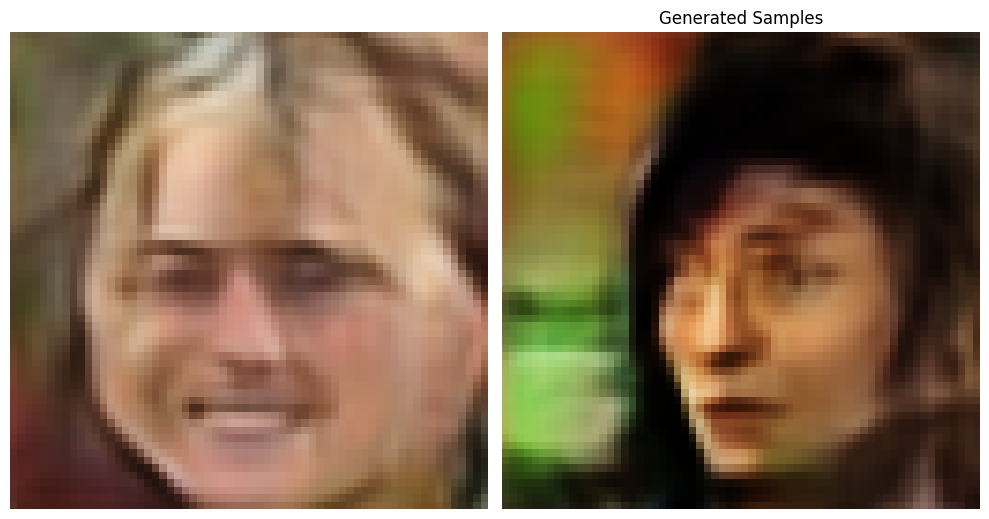

In [21]:
visualize_samples(gen, noise_dim=128, num_samples=2)

In [ ]:
g